# Handwritten text (full name) recognition using ANNs

### Made by Sneha Kedia, Aayushi Shrivastava, D. Ritika

***

Before beginning we will define how we want our program to work.

In [1]:
# Defined to download data from the original database or use the dataset one already provided and preprocessed
# Here, we use:
# 'load': to load the datase from the directory
# We can also use:
# 'download': to download data from the database and process the images
dataset_load_method = 'load'

# Defined to save the dataset to a file
save_dataset = False

# Defined to load the trained classifiers from the directory
load_classifiers = False

# Defined to save the trained classifiers to a file
save_classifiers = True

# Defined to save classification test output to a file
save_results = True
if (save_results):
    result_output_file = open('result_output.txt','w') 

# Defined to print errors and warnings
enable_error_output = False

We need to install a few libraries here:

pip install plotly

pip install joblib

pip install opencv-python

pip install numpy --upgrade

pip install scikit-image --upgrade

# 1. Library imports

We import the needed libraries to run our code.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import scipy
import sklearn
import pandas as pd
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage import data, color, exposure, measure
from skimage.transform import resize
from skimage.feature import hog
from sklearn.manifold import TSNE
import joblib
import urllib
from io import StringIO
import cv2
from scipy import ndimage
from difflib import SequenceMatcher
from sys import stdout
from IPython.display import clear_output

//anaconda3/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



We will also define a small function for displaying purposes:

In [3]:
def print_percentage(prct, msg=None):
    if (prct > 100 or prct < 0):
        return
    clear_output(wait=True)
    if (msg == None):
        stdout.write("Progress: [")
    else:
        stdout.write(msg+" [")
    end = int(int(prct)/10)
    for i in range(0, end):
        stdout.write("=")
    for i in range(end, 10):
        stdout.write(" ")
    stdout.write("] "+str(prct)+"%")
    stdout.flush()

# 2. Importing the dataset with the urls and names

We import the "Transcriptions of handwriten text" database obtained from https://www.crowdflower.com/data-for-everyone/ (Now available at https://appen.com/datasets/handwritten-name-transcription-from-an-image/). As the csv file in the website has some errors, we fixed those errors using a small program written in Java (see java file included in source: database_fix.java).

In [4]:
df=pd.read_csv('first_and_last_names_fix.csv', sep=',',header=None)

In [5]:
df.head()

,0,1,2,3
0,_unit_id,image_url,transcription,first_or_last
1,952459271,http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...,HIMELIN,first
2,952459272,http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...,ROBIN,first
3,952459273,http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...,YOANN,first
4,952459274,http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...,MARTIN,first


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129990 entries, 0 to 129989
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       129990 non-null  object
 1   1       129990 non-null  object
 2   2       129904 non-null  object
 3   3       129990 non-null  object
dtypes: object(4)
memory usage: 4.0+ MB


***

### Functions to create the full dataset and labels

As the database _df_ we imported doesn't contain the images but link to the corresponding images, we need to download them and create a dataset with those and the labels.

The *_delborders_* function eliminates the bottom border noise in case of "first_b" and "last_b" types in the dataset.

In [7]:
def delborders(crop):
    cropf = ndimage.gaussian_filter(crop, 0.5)
    cropbin = (cropf<0.8)
    labeled, nr_objects = ndimage.label(cropbin)
    labels_to_delete = []
    for i in range(0, labeled.shape[1]):
        if (labeled[labeled.shape[0]-1][i] > 0):
            labels_to_delete.append(labeled[labeled.shape[0]-1][i])
    
    label_in_delete = False
    for x in range(0, labeled.shape[1]):
        for y in range(0, labeled.shape[0]):
            label_in_delete = False
            for l in range(0, len(labels_to_delete)):
                if (labeled[y][x] == labels_to_delete[l]):
                    label_in_delete = True
            
            if(label_in_delete):
                crop[y][x] = 1.0
    
    return crop

The *_getcrop_* function obtains an image from an entry of the database and returns the image in grayscale and cropped to show just the name part.

In [8]:
def getcrop(n):
    try: 
        urllib.request.urlretrieve(df[1][n], "temp.jpg")
    except urllib.error.URLError as e:
        return None, False
    img = cv2.imread('temp.jpg')
    imgh, imgw = img.shape[:-1]
    img_rgb = img.copy()
    template = cv2.imread('template.png')
    h, w = template.shape[:-1]

    template_match_success = False
    res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
    threshold = .7
    loc = np.where(res >= threshold)
    for pt in zip(*loc[::-1]):  # Switch collumns and rows
        cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
        croph1 = pt[1]
        croph2 = pt[1]+h
        cropw = pt[0] + w
        template_match_success = True

    if (not template_match_success):
        #Template matching has failed so return...
        return img, False

    if (df[3][n] == 'first' or df[3][n] == 'last'):
        crop = img.copy()[max(croph1-6, 0):min(croph2+6, imgh), cropw:imgw]
    else:
        crop = img.copy()[max(min(croph2+4, imgh-1), 0):imgh, :]
        
    crop = color.rgb2gray(crop)
    if (df[3][n] == 'first_b' or df[3][n] == 'last_b'):
        crop = delborders(crop)
    return crop, True

Next we define the gen_dataset function, this function creates a binarized image list "_data_" and a label list "_labels_" from the first _n_ entries of the database (if not specified uses all the entries of the database) using the crops of the _getcrop_ function and its corresponding label on that index.

In [9]:
def gen_dataset(n=df.shape[0]):
    data = []
    labels = []
    for i in range(1, n):
        crop, success = getcrop(i)
        if (success):
            data.append(crop)
            labels.append(df[2][i])
        else:
            if (enable_error_output):
                print("[WARNING] Template matching has failed for image: "+str(i))
        print_percentage((i*100/(n-1)), "Fetched "+str(i)+" images:")
    
    print_percentage(100, "Fetched "+str(n-1)+" images:")
    print("")
    print("Finished!")
    return data, labels

### Obtaining the dataset

Now we can download and create the whole dataset and its corresponding label list or load the dataset from the saved files. The process takes a while to complete...

In [10]:
# Obtain dataset from original data if defined (we can define how much data of the 
# original database we want to use to the function or leave it blank to use all the data)
if (dataset_load_method == 'download'):
    dataset, labels = gen_dataset(10000)

# Load dataset from files
if (dataset_load_method == 'load'):
    dataset = np.load("HandwrittenNames_data.npz",allow_pickle=True)['data']
    labels = np.load("HandwrittenNames_labels.npz")['data']

If specified, the generated dataset can be saved to .npz files using these functions.

In [11]:
# Save dataset to a file if defined
if (save_dataset):
    np.savez("HandwrittenNames_data.npz", data=dataset)
    np.savez("HandwrittenNames_labels.npz", data=labels)

We can plot some images and print their corresponding labels to check that everything is correct: 

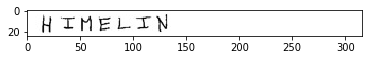

HIMELIN
<class 'numpy.str_'>


In [12]:
# Change selection to plot a different image and label
selection = 0
plt.imshow(dataset[selection], cmap='gray')
plt.show()
print(labels[selection])
print(str(type(labels[0])))

# 3. Defining extra helpful functions

In this section of the notebook we will define some functions that will be useful later on.

### get_labels

This function labels the connected components in an image by binarizing it and running a clustering method, it returns the labels and the number of labels it detects.

In [13]:
def get_labels(crop):
    img = crop.copy() # gray-scale image

    # You could smooth the image (to remove small objects) but we saw better results without using it...
    # blur_radius = 0.5
    # imgf = ndimage.gaussian_filter(img, blur_radius)

    threshold = 0.8

    # Find connected components
    labeled, nr_objects = ndimage.label(img<threshold) 
    #print("Number of objects is " +str(nr_objects))

    return labeled, nr_objects

### get_bboxes

This function gets the bounding boxes to cut each character correctly given the labels obtained from get_labels. It returns a list of each character's bounding boxes (2 2D points).

In [14]:
def get_bboxes(labeled, nr_objects):
    bboxes = np.zeros((nr_objects, 2, 2), dtype='int')

    x1, y1, x2, y2 = 0, labeled.shape[0], 0, 0
    coord = 0
    cont = 0
    ytop, ybot = 0, 0
    nzero, firstb = False, False

    for x in range(0, labeled.shape[1]):
        nzero, firstb = False, False
        ytop, ybot = 0, 0
        for y in range(0, labeled.shape[0]):
            if (labeled[y][x] > 0):
                nzero = True
                if (not firstb):
                    ytop = y
                    firstb = True
                ybot = y

        if (nzero):
            if (ytop < y1):
                y1 = ytop
            if (ybot > y2):
                y2 = ybot
            if (coord == 0):
                x1 = x
                coord = 1
            elif (coord == 1):
                x2 = x
        elif ((not nzero) and (coord == 1)):
            bboxes[cont][0] = [x1, y1]
            bboxes[cont][1] = [x2, y2]
            cont += 1
            coord = 0
            x1, y1, x2, y2 = 0, labeled.shape[0], 0, 0

    bboxes = bboxes[0:cont]
    return bboxes, cont

### crop_characters

Given an image and character bounding boxes this function crops each character in an image and returns each character's corresponding binarized image in a list.

In [15]:
def crop_characters(img, bboxes, n):
    characters = []
    for i in range(0, n):
        c = img.copy()[bboxes[i][0][1]:bboxes[i][1][1], bboxes[i][0][0]:bboxes[i][1][0]]
        if (c.shape[0] != 0 and c.shape[1] != 0):
            c = resize(c, (28, 28), mode='constant', cval=1.0, clip=True)
            characters.append((c<0.80).reshape(784))
    return characters, len(characters)

### labelsep

Separates a full name label into a character list. Useful for the training part to have the labels of each character.

In [16]:
def labelsep(label):
    if (type(label) is str or type(label) is np.str_):
        decomposed_label = list(label)
        labels = []
        for i in range(0, len(decomposed_label)):
            if (decomposed_label[i] != ' '):
                labels.append(decomposed_label[i])
        return labels
    else:
        return []

### get_characters

Given an image from the dataset and its label this function splits each character into one image and a label. The img_only variant doesn't return the labels (useful when testing with full names to save some memory and time).

In [17]:
def get_characters(image, label):
    labeled, nr_objects = get_labels(image)
    bboxes, n = get_bboxes(labeled, nr_objects)
    characters, n_chars = crop_characters(image, bboxes, n)
    labels = labelsep(label)
    return characters, labels[0:n_chars]

def get_characters_img_only(image):
    labeled, nr_objects = get_labels(image)
    bboxes, n = get_bboxes(labeled, nr_objects)
    characters, n_chars = crop_characters(image, bboxes, n)
    return characters

## Checking results

We can check if it extracts correctly all the data with these plots and prints

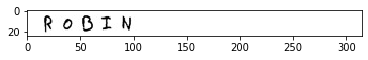

ROBIN


In [18]:
selection = 1
plt.imshow(dataset[selection], cmap='gray')
plt.show()
print(labels[selection])

In [19]:
characters, charlabels = get_characters(dataset[selection], labels[selection])

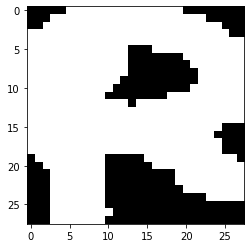

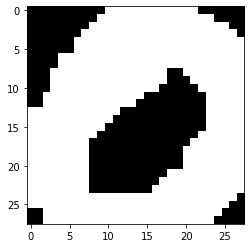

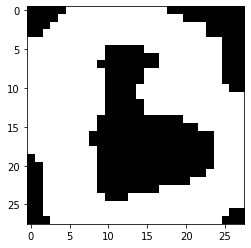

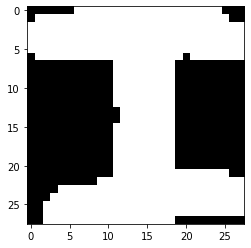

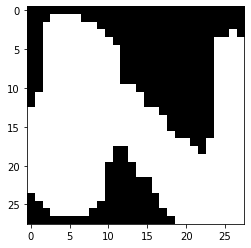

['R', 'O', 'B', 'I', 'N']


In [20]:
for i in range(0, len(characters)):
    plt.imshow(characters[i].reshape(28,28), cmap='gray')
    plt.show()
    
print(str(charlabels))

# 4. Defining our models

We will define our four classifiers: MLP with RBM features, MLP with HOG features, MLP with PCA features and MLP only.

In [21]:
# Define if we want to print status of the training process
verbose_classifiers = True

### MLP with RBM features
We define a RBM with 300 components and a MLP with 3 layers of 300, 400 and 150 neurons respectively. Then whe combine them together into a Scikit-Learn Pipeline to chain the features of the RBM to the input of the MLP.

MLP: Multilayer Perceptron
RBM: Restricted Boltzmann Machine

In [22]:
# RBM Definition
rbm = BernoulliRBM(n_components=300, learning_rate=0.01, n_iter=45, random_state=0, verbose=verbose_classifiers)

# MLP Classifier Definition 
mlp = MLPClassifier(hidden_layer_sizes=(300,400,150), activation='relu', max_iter=5000, tol=0.0001, random_state=1, verbose=verbose_classifiers)

# We define the pipeline afterwards: MLP Classifier with RBM features
rbm_mlp_classifier = Pipeline(steps=[('rbm', rbm), ('mlp', mlp)])

### MLP with HOG features
We define a MLP with 3 layers of 300, 400 and 150 neurons respectively to train it with the HOG features later on.

In [23]:
# MLP Classifier with HOG (Histogram of Oriented Gradients) features
mlp_classifier_HOG = MLPClassifier(hidden_layer_sizes=(300,400,150), max_iter=5000, tol=0.001, random_state=1, verbose=verbose_classifiers)

### MLP with PCA features
We define a MLP with 3 layers of 300, 400 and 150 neurons respectively to train it with the PCA features later on.

In [24]:
# MLP Classifier with PCA (Principal Component Analisis) features
mlp_classifier_PCA = MLPClassifier(hidden_layer_sizes=(300,400,150), max_iter=5000, tol=0.0001, random_state=1, verbose=verbose_classifiers)

### MLP
We define a MLP with 3 layers of 300, 400 and 150 neurons respectively to train it with the data later.

In [25]:
# MLP Only classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(300,400,150), max_iter=5000, tol=0.0001, random_state=1, verbose=verbose_classifiers)

# 5. Preparing the train and test batches

### Splitting the dataset into train and test batches

We divide the dataset into 80% train 20% test batches:

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset, labels, test_size=0.2, random_state=0)

In [27]:
print("Train batch lenghts:")
print("X_train size: "+str(len(X_train)))
print("Y_train size: "+str(len(Y_train)))
print("")
print("Test batch lenghts:")
print("X_test size: "+str(len(X_test)))
print("Y_test size: "+str(len(Y_test)))

Train batch lenghts:
X_train size: 7985
Y_train size: 7985

Test batch lenghts:
X_test size: 1997
Y_test size: 1997


### Processing the train and test batches for characters

We process the train and test batches to divide the batches into single character batches instead of full names, this is needed to train and will be useful in case of the test to test per character precision later on.

In [28]:
X_train_chars = []
Y_train_chars = []
Train_with_inconsistencies = []
z = 0
for i in range(0, len(X_train)):
    print_percentage(i*100/len(X_train), "Processing train image "+ str(i)+" :")
    characters, charlabels = get_characters(X_train[i], Y_train[i])
    if (len(characters) != len(charlabels) or len(characters) == 0 or len(charlabels) == 0):
        if (enable_error_output):
            print("[Warning] Input number "+str(i)+" inconsistent! Skipping this one...")
        Train_with_inconsistencies.append(i)
        z += 1
    else:
        X_train_chars.extend(characters)
        Y_train_chars.extend(charlabels)

print_percentage(100, "Processing train image "+ str(len(X_train))+" :")
print("")
print(str(100-(z*100/len(X_train)))+"% of the data in train batch correctly extracted.")

Processing train image 7985 : [==========] 100%
94.16405760801503% of the data in train batch correctly extracted.


In [29]:
print("Character splitted train batch lenghts:")
print("X_train_chars size: "+str(len(X_train_chars)))
print("Y_train_chars size: "+str(len(Y_train_chars)))

Character splitted train batch lenghts:
X_train_chars size: 43802
Y_train_chars size: 43802


In [30]:
X_test_chars = []
Y_test_chars = []
Test_without_inconsistencies = []
z = 0
for i in range(0, len(X_test)):
    print_percentage(i*100/len(X_test), "Processing test image "+ str(i)+" :")
    characters, charlabels = get_characters(X_test[i], Y_test[i])
    if (len(characters) != len(charlabels) or len(characters) == 0 or len(charlabels) == 0):
        if (enable_error_output):
            print("[Warning] Input number "+str(i)+" inconsistent! Skipping this one...")
        z += 1
    else:
        X_test_chars.extend(characters)
        Y_test_chars.extend(charlabels)
        Test_without_inconsistencies.append(i)

print_percentage(100, "Processing train image "+ str(len(X_test))+" :")
print("")
print(str(100-(z*100/len(X_test)))+"% of the data in test batch correctly extracted.")

Processing train image 1997 : [==========] 100%
94.04106159238859% of the data in test batch correctly extracted.


In [31]:
print("Character splitted test batch lenghts:")
print("X_test_chars size: "+str(len(X_test_chars)))
print("Y_test_chars size: "+str(len(Y_test_chars)))

Character splitted test batch lenghts:
X_test_chars size: 11013
Y_test_chars size: 11013


### Calculate the Histogram of Oriented Gradients

We calculate the Histogram of Oriented Gradients for the MLP_HOG classifier.

In [32]:
fd_train = np.zeros((len(X_train_chars),392))
for i in range(0,len(X_train_chars)):
    print_percentage(i*100/len(X_train_chars), "Processing train image "+ str(i)+" :")
    fd_train[i], hog_image = hog(X_train_chars[i].reshape(28,28).astype('uint8'), orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize = True) 

print_percentage(100, "Processing train image "+ str(len(X_train_chars))+" :")

print("")
fd_test = np.zeros((len(X_test_chars),392))
for i in range(0,len(X_test_chars)):
    print_percentage(i*100/len(X_test_chars), "Processing test image "+ str(i)+" :")
    fd_test[i], hog_image = hog(X_test_chars[i].reshape(28,28).astype('uint8'), orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize = True) 
    
print_percentage(100, "Processing train image "+ str(len(X_test_chars))+" :")
print("")
print("Finished!")

Processing train image 11013 : [==========] 100%
Finished!


In [33]:
# We also define a function in case we need to transform something later
def HOG_transform(chars):
    fd_hog = np.zeros((len(chars),392))
    for i in range(0, len(chars)):
        fd_hog[i], hog_image = hog(chars[i].reshape(28,28).astype('uint8'), orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize = True)
    return fd_hog

# This function is for visualizing the HOG
def get_HOG_image(char):
    fd_hog = np.zeros((392))
    fd_hog, hog_image = hog(char.reshape(28,28).astype('uint8'), orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize = True)
    return hog_image

UPDATE: hog(char.reshape(28,28).astype('uint8')

We can see how a hog transformed image looks:

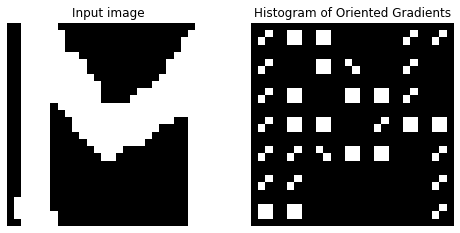

In [34]:
selection = 50

hog_image = get_HOG_image(X_train_chars[selection])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(X_train_chars[selection].reshape(28,28), cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')
plt.show()

### Transform the data to extract Principal Component Analysis features

We transform the data to extract Principal Component Analysis features for the MLP_PCA classifier.

In [35]:
# Standardising the values
Scaler = StandardScaler().fit(X_train_chars)
X_pca_train = Scaler.transform(X_train_chars)
# Call the PCA method with 100 components. 
pca = PCA(n_components=100)
pca.fit(X_pca_train)
P_train = pca.transform(X_pca_train)

# Standardising the values
X_pca_test = Scaler.transform(X_test_chars)

# Call the PCA method with 100 components. 
P_test = pca.transform(X_pca_test)

In [36]:
# We also define a function in case we need to transform something later
def PCA_transform(chars):
    # Standardising the values
    X_pca = Scaler.transform(chars)

    # Call the PCA method with 100 components. 
    P = pca.transform(X_pca)
    return P

We can see how the PCA looks like (only 2 PCA components):

In [37]:
print_limit = 1000
Target = Y_train_chars[:print_limit]
Target_colors = Y_train_chars[:print_limit]
for i in range(0, len(Target_colors)):
    Target_colors[i] = ord(Target_colors[i])
Characters = go.Scatter(
    x = P_train[:print_limit,0],
    y = P_train[:print_limit,1],
    hoveron = "fills",
    mode = 'markers',
    text = Target,
    showlegend = True,
    marker = dict(
        size = 8,
        color = Target_colors,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [Characters]

layout = go.Layout(
    title= 'Principal Component Analysis (PCA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

# 6. Training

### Training/loading classifiers

We feed the train characters and train character labels to each classifier or load the already trained classifiers from files (depending on the selected option):

In [38]:
if (not load_classifiers):
    rbm_mlp_classifier.fit(X_train_chars[:], Y_train_chars)
else:
    rbm = joblib.load('RBM.pkl')
    mlp = joblib.load('MLP_withRBMfeatures.pkl')
    rbm_mlp_classifier = joblib.load('RBM_MLP_classifier.pkl')

[BernoulliRBM] Iteration 1, pseudo-likelihood = -229.56, time = 12.64s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -193.61, time = 14.66s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -185.11, time = 14.49s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -166.97, time = 14.38s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -164.94, time = 14.40s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -165.26, time = 14.21s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -154.19, time = 14.34s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -164.25, time = 14.37s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -147.70, time = 14.37s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -158.48, time = 14.38s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -153.00, time = 14.32s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -154.08, time = 14.29s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -152.88, time = 14.22s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -159.99, time = 14.30s
[

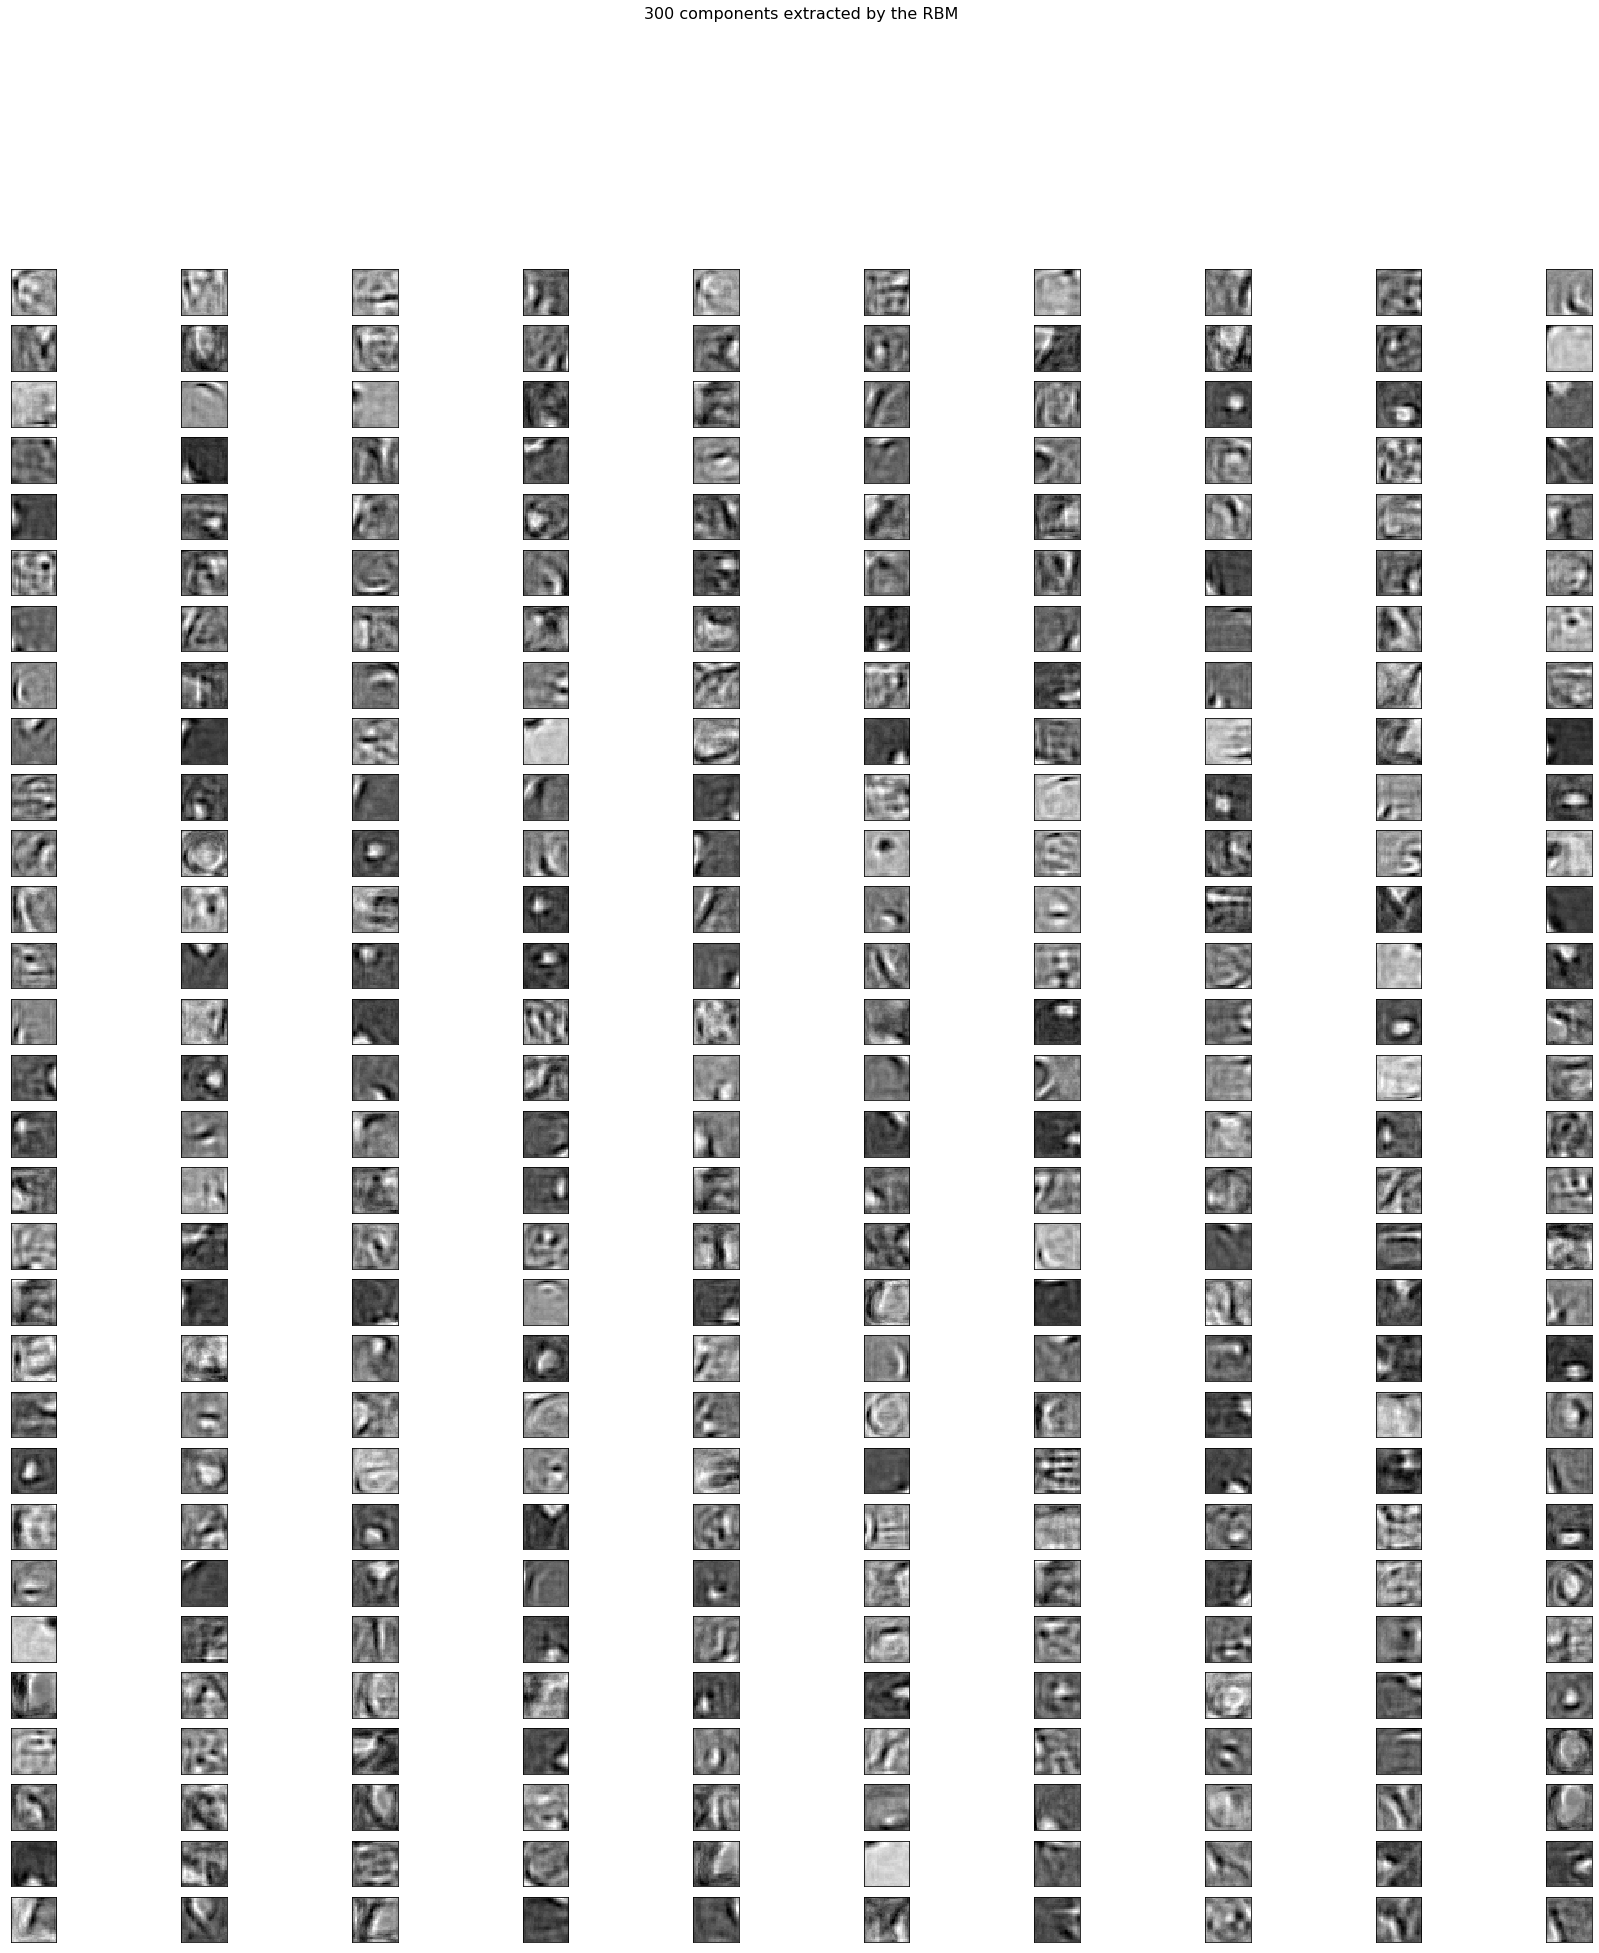

In [39]:
# We can define if we want to plot the components extracted by the RBM
plot_rbm_features = True

if (plot_rbm_features):
    plt.figure(figsize=(28, 28))
    for i, comp in enumerate(rbm.components_):
        plt.subplot(30, 10, i+1)
        plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.suptitle('300 components extracted by the RBM', fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

    plt.show()

In [40]:
if (not load_classifiers):
    mlp_classifier_HOG.fit(fd_train,Y_train_chars)
else:
    mlp_classifier_HOG = joblib.load('MLP_HOG.pkl')

Iteration 1, loss = 0.81363791
Iteration 2, loss = 0.43744359
Iteration 3, loss = 0.37364218
Iteration 4, loss = 0.33155110
Iteration 5, loss = 0.29241227
Iteration 6, loss = 0.25926400
Iteration 7, loss = 0.22657031
Iteration 8, loss = 0.19539589
Iteration 9, loss = 0.17359571
Iteration 10, loss = 0.13919254
Iteration 11, loss = 0.11494402
Iteration 12, loss = 0.09158096
Iteration 13, loss = 0.07039460
Iteration 14, loss = 0.05408842
Iteration 15, loss = 0.04473609
Iteration 16, loss = 0.03359720
Iteration 17, loss = 0.02896706
Iteration 18, loss = 0.02722635
Iteration 19, loss = 0.03600974
Iteration 20, loss = 0.03361994
Iteration 21, loss = 0.01977313
Iteration 22, loss = 0.01482944
Iteration 23, loss = 0.02444886
Iteration 24, loss = 0.02070886
Iteration 25, loss = 0.02097661
Iteration 26, loss = 0.02488502
Iteration 27, loss = 0.02795333
Iteration 28, loss = 0.02028543
Iteration 29, loss = 0.01359272
Iteration 30, loss = 0.01453629
Iteration 31, loss = 0.01501388
Iteration 32, los

In [41]:
if (not load_classifiers):
    mlp_classifier_PCA.fit(P_train,Y_train_chars)
else:
    mlp_classifier_PCA = joblib.load('MLP_PCA.pkl')

Iteration 1, loss = 0.66038272
Iteration 2, loss = 0.36930746
Iteration 3, loss = 0.29917503
Iteration 4, loss = 0.24635718
Iteration 5, loss = 0.20444082
Iteration 6, loss = 0.17110537
Iteration 7, loss = 0.14081813
Iteration 8, loss = 0.10861284
Iteration 9, loss = 0.08949446
Iteration 10, loss = 0.07151939
Iteration 11, loss = 0.06174275
Iteration 12, loss = 0.04541816
Iteration 13, loss = 0.04260971
Iteration 14, loss = 0.03633324
Iteration 15, loss = 0.04235271
Iteration 16, loss = 0.03496537
Iteration 17, loss = 0.03013069
Iteration 18, loss = 0.02604914
Iteration 19, loss = 0.03299460
Iteration 20, loss = 0.04167068
Iteration 21, loss = 0.03346853
Iteration 22, loss = 0.03070840
Iteration 23, loss = 0.02618757
Iteration 24, loss = 0.02084661
Iteration 25, loss = 0.02747061
Iteration 26, loss = 0.02551705
Iteration 27, loss = 0.02897754
Iteration 28, loss = 0.02176069
Iteration 29, loss = 0.02468837
Iteration 30, loss = 0.02730389
Iteration 31, loss = 0.02464082
Iteration 32, los

In [42]:
if (not load_classifiers):
    mlp_classifier.fit(X_train_chars, Y_train_chars)
else:
    mlp_classifier = joblib.load('MLP.pkl')

Iteration 1, loss = 0.74811511
Iteration 2, loss = 0.46812795
Iteration 3, loss = 0.38762421
Iteration 4, loss = 0.31838334
Iteration 5, loss = 0.30646764
Iteration 6, loss = 0.25570863
Iteration 7, loss = 0.22903234
Iteration 8, loss = 0.21230072
Iteration 9, loss = 0.22842977
Iteration 10, loss = 0.17055137
Iteration 11, loss = 0.15558714
Iteration 12, loss = 0.13139001
Iteration 13, loss = 0.18737072
Iteration 14, loss = 0.12207242
Iteration 15, loss = 0.10165542
Iteration 16, loss = 0.08629364
Iteration 17, loss = 0.07217150
Iteration 18, loss = 0.07178364
Iteration 19, loss = 0.06482870
Iteration 20, loss = 0.05829696
Iteration 21, loss = 0.04661927
Iteration 22, loss = 0.06574767
Iteration 23, loss = 0.05542893
Iteration 24, loss = 0.05164366
Iteration 25, loss = 0.03818650
Iteration 26, loss = 0.04185744
Iteration 27, loss = 0.07473954
Iteration 28, loss = 0.03078654
Iteration 29, loss = 0.02918237
Iteration 30, loss = 0.03729526
Iteration 31, loss = 0.03916784
Iteration 32, los

### Saving the classifiers

If enabled, this will save the trained models to files.

In [43]:
# Save the classifiers if enabled:
if (save_classifiers):
    joblib.dump(rbm, 'RBM.pkl')
    joblib.dump(mlp, 'MLP_withRBMfeatures.pkl')
    joblib.dump(rbm_mlp_classifier, 'RBM_MLP_classifier.pkl')
    joblib.dump(mlp_classifier_HOG, 'MLP_HOG.pkl')
    joblib.dump(mlp_classifier_PCA, 'MLP_PCA.pkl')
    joblib.dump(mlp_classifier, 'MLP.pkl')

# 7. Testing the results

### Functions for testing results later

predict_full_name given a full name image and a classifier divides the image into characters and asks the classifier to predict it, afterwards chains the predictions of each characters into a full string.

In [44]:
# transform should be 'hog' for MLP_HOG classifier and 'pca' for MLP_PCA classifier, otherwise None
def predict_full_name(name, classifier, transform=None):
    characters = get_characters_img_only(name)
    if (transform == 'hog'):
        prediction = classifier.predict(HOG_transform(characters))
    elif (transform == 'pca'):
        prediction = classifier.predict(PCA_transform(characters))
    else:
        prediction = classifier.predict(characters)
    strg = ''
    for i in range(0, len(prediction)):
        strg = strg+prediction[i]
    return strg

predict_full_names gets the prediction for each consistent test data and returns the correct ratio and correlation ratio.

In [45]:
# transform should be 'hog' for MLP_HOG classifier and 'pca' for MLP_PCA classifier, otherwise None
def predict_full_names(classifier, transform=None):
    correlation=0.0
    correct = 0
    for i in range(0,len(Test_without_inconsistencies)):
        predicted_name = predict_full_name(X_test[Test_without_inconsistencies[i]], classifier, transform)
        if (predicted_name == Y_test[Test_without_inconsistencies[i]]):
            correct += 1
        correlation += similar(predicted_name, Y_test[Test_without_inconsistencies[i]])
        print_percentage(i*100/len(X_test),"Making predictions "+str(i)+"/"+str(len(X_test))+":")
    print_percentage(100,"Making predictions "+str(len(X_test))+"/"+str(len(X_test))+":")
    return (correct/len(Test_without_inconsistencies)), (correlation/len(Test_without_inconsistencies))

similar gives a correlation ratio between two strings.

In [46]:
def similar(a,b):
        return SequenceMatcher(None,a,b).ratio()

### Testing character recognintion

We will test now individual character recognition scores for each classifier using the test batch.

In [47]:
rbm_mlp_prediction = rbm_mlp_classifier.predict(X_test_chars)
mlp_prediction_HOG = mlp_classifier_HOG.predict(fd_test)
mlp_prediction_PCA = mlp_classifier_PCA.predict(P_test)
mlp_prediction = mlp_classifier.predict(X_test_chars)

In [48]:
print("MLP classification using RBM features:\n%s\n" % (metrics.classification_report(Y_test_chars, rbm_mlp_prediction)))
print("HOG + MLP classification:\n%s\n" % (metrics.classification_report(Y_test_chars, mlp_prediction_HOG)))
print("PCA + MLP classification:\n%s\n" % (metrics.classification_report(Y_test_chars, mlp_prediction_PCA)))
print("MLP only classification:\n%s\n" % (metrics.classification_report(Y_test_chars, mlp_prediction)))

if (save_results):
    result_output_file.write("MLP classification using RBM features:\n%s\n" % (metrics.classification_report(Y_test_chars, rbm_mlp_prediction)))
    result_output_file.write("\nHOG + MLP classification:\n%s\n" % (metrics.classification_report(Y_test_chars, mlp_prediction_HOG)))
    result_output_file.write("\nPCA + MLP classification:\n%s\n" % (metrics.classification_report(Y_test_chars, mlp_prediction_PCA)))
    result_output_file.write("\nMLP only classification:\n%s\n" % (metrics.classification_report(Y_test_chars, mlp_prediction)))

MLP classification using RBM features:
              precision    recall  f1-score   support

           -       0.75      0.25      0.38        24
           A       0.94      0.93      0.94      1686
           B       0.80      0.71      0.75        98
           C       0.91      0.91      0.91       305
           D       0.81      0.79      0.80       183
           E       0.94      0.95      0.94      1471
           F       0.66      0.41      0.51        61
           G       0.91      0.85      0.88       110
           H       0.78      0.82      0.80       327
           I       0.85      0.94      0.90       979
           J       0.92      0.62      0.74       109
           K       0.72      0.71      0.72        48
           L       0.96      0.95      0.96      1000
           M       0.87      0.83      0.85       571
           N       0.91      0.94      0.93      1060
           O       0.89      0.93      0.91       598
           P       0.78      0.77      0.7

### Testing full name recognition

We will test now full name recognition scores using the consistent test batch.

In [49]:
correct_rbm_mlp, corr_rbm_mlp = predict_full_names(rbm_mlp_classifier)

Making predictions 1997/1997: [==========] 100%

In [50]:
correct_mlp_HOG, corr_mlp_HOG = predict_full_names(mlp_classifier_HOG, 'hog')
correct_mlp_PCA, corr_mlp_PCA = predict_full_names(mlp_classifier_PCA, 'pca')
correct_mlp, corr_mlp = predict_full_names(mlp_classifier)

Making predictions 1997/1997: [==========] 100%

In [51]:
print("Full name test results: ")
print("========================================================================")
print("| Classifier            | Correct percentage      | Correlation ratio  |")
print("========================================================================")
print("| MLP with RBM features | "+str(correct_rbm_mlp)+"     | "+str(corr_rbm_mlp)+" |")
print("========================================================================")
print("| MLP with HOG features | "+str(correct_mlp_HOG)+"     | "+str(corr_mlp_HOG)+" |")
print("========================================================================")
print("| MLP with PCA features | "+str(correct_mlp_PCA)+"     | "+str(corr_mlp_PCA)+" |")
print("========================================================================")
print("| MLP only              | "+str(correct_mlp)+"     | "+str(corr_mlp)+" |")
print("========================================================================")

if (save_results):
    result_output_file.write("\n\nFull name test results: ")
    result_output_file.write("\n========================================================================")
    result_output_file.write("\n| Classifier            | Correct percentage      | Correlation ratio  |")
    result_output_file.write("\n========================================================================")
    result_output_file.write("\n| MLP with RBM features | "+str(correct_rbm_mlp)+"     | "+str(corr_rbm_mlp)+" |")
    result_output_file.write("\n========================================================================")
    result_output_file.write("\n| MLP with HOG features | "+str(correct_mlp_HOG)+"     | "+str(corr_mlp_HOG)+" |")
    result_output_file.write("\n========================================================================")
    result_output_file.write("\n| MLP with PCA features | "+str(correct_mlp_PCA)+"     | "+str(corr_mlp_PCA)+" |")
    result_output_file.write("\n========================================================================")
    result_output_file.write("\n| MLP only              | "+str(correct_mlp)+"     | "+str(corr_mlp)+" |")
    result_output_file.write("\n========================================================================")

Full name test results: 
| Classifier            | Correct percentage      | Correlation ratio  |
| MLP with RBM features | 0.626730564430245     | 0.9116639129777215 |
| MLP with HOG features | 0.6379126730564431     | 0.9138392522609192 |
| MLP with PCA features | 0.6485623003194888     | 0.9157361214366638 |
| MLP only              | 0.6682641107561236     | 0.9228395970044416 |


### Visual testing

We can see some predictions visually here by adding indexes to the "indexes" list and for each test data selected in "indexes" we will see the predictions of each classifier.

> Real label: BASTIEN
> Image:


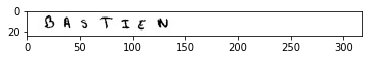

MLP with RBM features predicted: BMSTIEN
MLP with HOG features predicted: AAITIEN
MLP with PCA features predicted: BASTIEN
MLP predicted: BASTIEN

> Real label: MATTHIEU
> Image:


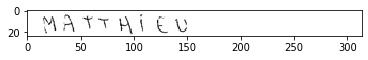

MLP with RBM features predicted: MBTTHIEU
MLP with HOG features predicted: MATTHIEU
MLP with PCA features predicted: MATTMILU
MLP predicted: MATTHIEU

> Real label: TESSA
> Image:


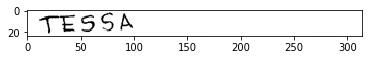

MLP with RBM features predicted: TSSA
MLP with HOG features predicted: TSSA
MLP with PCA features predicted: TSSA
MLP predicted: TSSA

> Real label: AYMERIC
> Image:


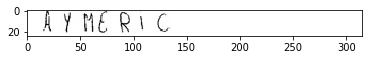

MLP with RBM features predicted: AYMERIC
MLP with HOG features predicted: AYMERIC
MLP with PCA features predicted: AYMERIC
MLP predicted: AYMERIC

> Real label: ELSA
> Image:


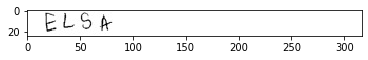

MLP with RBM features predicted: ELSA
MLP with HOG features predicted: ELSA
MLP with PCA features predicted: ELSA
MLP predicted: ELSA



In [52]:
indexes = [8, 10, 12, 14, 16]
for ind in indexes:
    rbm_mlp_predict = predict_full_name(X_test[ind], rbm_mlp_classifier)
    mlp_hog_predict = predict_full_name(X_test[ind], mlp_classifier_HOG, 'hog')
    mlp_pca_predict = predict_full_name(X_test[ind], mlp_classifier_PCA, 'pca')
    mlp_predict = predict_full_name(X_test[ind], mlp_classifier)
    print("> Real label: "+Y_test[ind])
    print("> Image:")
    plt.imshow(X_test[ind], cmap='gray')
    plt.show()
    print("MLP with RBM features predicted: "+rbm_mlp_predict)
    print("MLP with HOG features predicted: "+mlp_hog_predict)
    print("MLP with PCA features predicted: "+mlp_pca_predict)
    print("MLP predicted: "+mlp_predict)
    print("")
    
    if (save_results):
        result_output_file.write("\n\n> Real label: "+Y_test[ind])
        result_output_file.write("\nMLP with RBM features predicted: "+rbm_mlp_predict)
        result_output_file.write("\nMLP with HOG features predicted: "+mlp_hog_predict)
        result_output_file.write("\nMLP with PCA features predicted: "+mlp_pca_predict)
        result_output_file.write("\nMLP predicted: "+mlp_predict)
        result_output_file.write("\n")

In [53]:
if (save_results):
    result_output_file.close()